In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, log_loss

# For clear plotting of losses/errors
error_rate = []

## 📝 Project Description Document: General Information on Dataset (a.)

**a. General Information on dataset:**

1.  **Name of dataset used:** Credit Card Fraud Detection Dataset 2023 (`creditcard_2023.csv`)
2.  **Number of classes and their labels:** 2 classes. **Label 0** (Non-Fraudulent Transaction) and **Label 1** (Fraudulent Transaction).
3.  **Total number of samples in dataset:** 568,630
4.  **Size of each sample:** Not applicable (tabular data). The size is defined by the feature dimension (29).
5.  **Number of samples used in training, validation and testing (60/20/20 split):**
    * **Training Set (60%):** 341,178 samples (Used to train the classifier)
    * **Validation Set (20%):** 113,726 samples (Used to find the optimal $K$)
    * **Testing Set (20%):** 113,726 samples (Used for final, unbiased evaluation)

## 📖 Reading and Preparing Data

In [ ]:
Data = pd.read_csv('creditcard_2023.csv')
print("Data loaded and cleaning 'id' column.")
Data.drop((['id']), axis=1, inplace=True)
print(Data.head())

Data loaded and cleaning 'id' column.
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0 -0.130006  0.727159  0.637735  ... -0.110552  0.217606 -0.134794  0.165959   
1 -0.133118  0.347452  0.529808  ... -0.194936 -0.605761  0.079469 -0.577395   
2 -0.095576 -0.261297  0.690708  ... -0.005020  0.702906  0.945045 -1.154666   
3 -0.065130 -0.205698  0.575231  ... -0.146927 -0.038212 -0.214048 -1.893131   
4 -0.212660  1.049921  0.968046  ... -0.106984  0.729727 -0.161666  0.312561   

        V25       V26       V2

In [3]:
X = Data.drop('Class', axis=1)
y = Data['Class']

# 1. Split into temporary set (Train+Validation) and Test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Split temporary set into Train (60% of total) and Validation (20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features split and scaled.")
print(f"Train Set Size: {X_train_scaled.shape[0]}, Validation Set Size: {X_val_scaled.shape[0]}, Test Set Size: {X_test_scaled.shape[0]}")

Features split and scaled.
Train Set Size: 341178, Validation Set Size: 113726, Test Set Size: 113726


## ⚙️ Project Description Document: Implementation details (b.)

**b. Implementation details:**

1.  **At feature extraction phase:**
    * **Features extracted:** 29 features (`V1` through `V28` and `Amount`).
    * **Dimension of resulted features (input vector):** 29 dimensions. Features were scaled using `StandardScaler`.

2.  **Is cross-validation is used?** No. A dedicated 20% Validation Set is used specifically for tuning the $K$ hyperparameter.

3.  **Hyperparameters used in your model (KNeighborsClassifier):**
    * **Model:** `KNeighborsClassifier`
    * **Optimizer/Epochs:** Not applicable (KNN is a non-parametric, non-iterative model).
    * **Key Hyperparameter ($K$):** The optimal number of neighbors (`n_neighbors`) is determined by minimizing the error rate on the Validation Set.
    * **Tuning Range:** $K$ tested from 1 to 30.
    * **Distance Metric (`metric`):** 'minkowski' (Euclidean distance, $p=2$, by default).
    * **Weights (`weights`):** 'uniform' (all neighbors weighted equally).

## 🧠 Hyperparameter Tuning: Finding Optimal K (Loss Curve)

For KNN, the requirement for a "loss curve" is best met by plotting the **Error Rate** (1 - Accuracy) against a range of $K$ values, which is how the optimal hyperparameter is selected.

In [ ]:
error_rate = []
k_values = range(1, 31)

print("Starting hyperparameter tuning on Validation Set...")

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train on Training data
    knn.fit(X_train_scaled, y_train)
    
    # Predict on Validation data
    y_pred_val = knn.predict(X_val_scaled)
    
    # Calculate Error Rate (1 - Accuracy)
    error = 1 - accuracy_score(y_val, y_pred_val)
    error_rate.append(error)
    
    if k % 5 == 0:
        print(f"K={k}, Validation Error: {error:.4f}")

# Find the K with the minimum error
optimal_k = k_values[np.argmin(error_rate)]
min_error = np.min(error_rate)

print(f"\nOptimal K found: {optimal_k} with minimum Validation Error: {min_error:.4f}")

Starting hyperparameter tuning on Validation Set...
K=5, Validation Error: 0.0027
K=10, Validation Error: 0.0037
K=15, Validation Error: 0.0052
K=20, Validation Error: 0.0057
K=25, Validation Error: 0.0069
K=30, Validation Error: 0.0073

Optimal K found: 2 with minimum Validation Error: 0.0010


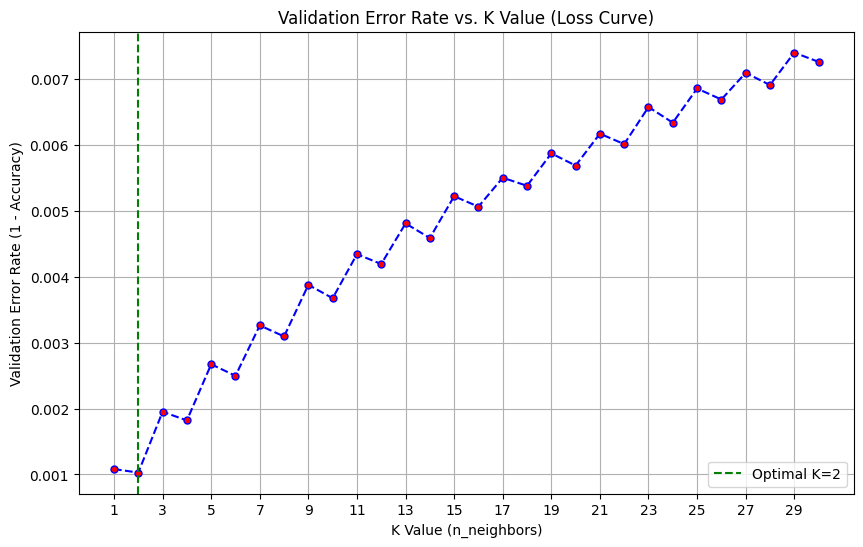

In [5]:
## Loss Curve (Error Rate vs. K)
plt.figure(figsize=(10, 6))
plt.plot(k_values, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)
plt.title('Validation Error Rate vs. K Value (Loss Curve)')
plt.xlabel('K Value (n_neighbors)')
plt.ylabel('Validation Error Rate (1 - Accuracy)')
plt.xticks(k_values[::2])
plt.axvline(x=optimal_k, color='g', linestyle='--', label=f'Optimal K={optimal_k}')
plt.legend()
plt.grid(True)
plt.show()

## 📊 Project Description Document: Results details (c.)

The final model is evaluated on the independent Test Set using the **Optimal K** determined from the Validation Set tuning phase.

In [6]:
# Final Model: Train with Optimal K and predict on Test Set
final_knn = KNeighborsClassifier(n_neighbors=optimal_k)
final_knn.fit(X_train_scaled, y_train)

# Predictions on Test Set
y_pred_test = final_knn.predict(X_test_scaled)
y_pred_prob = final_knn.predict_proba(X_test_scaled)[:, 1] # Probabilities for ROC curve

In [7]:
## Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy (Optimal K={optimal_k}): {accuracy:.4f}")

Test Set Accuracy (Optimal K=2): 0.9987


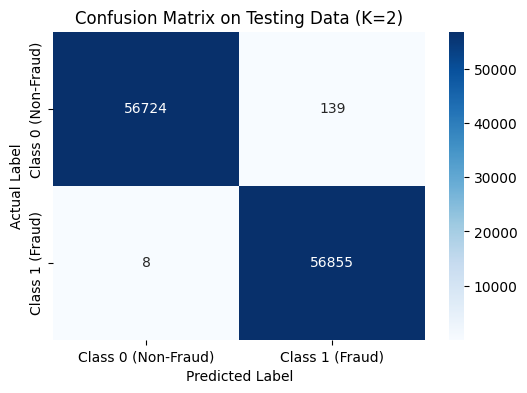

In [8]:
## Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0 (Non-Fraud)', 'Class 1 (Fraud)'], yticklabels=['Class 0 (Non-Fraud)', 'Class 1 (Fraud)'])
plt.title(f'Confusion Matrix on Testing Data (K={optimal_k})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

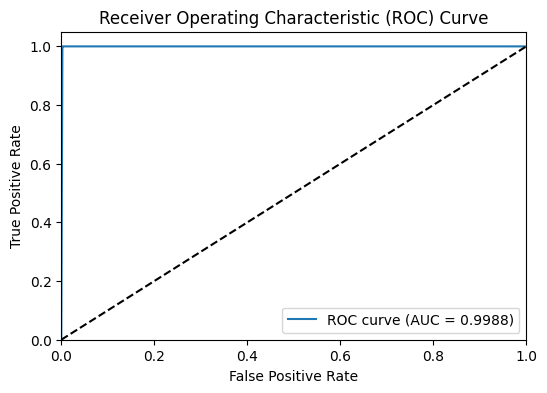

In [9]:
## ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()